# 6章 学習に関するテクニック

6.1 パラメータの更新

> 6.1.1 冒険家の話

> 6.1.2 SGD

（損失関数の勾配 × 学習係数）を直接引く。

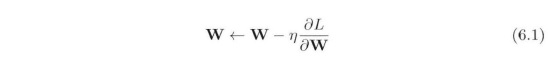

In [14]:
class SGD:
  def __init__(self, lr=0.01):
    self.lr = lr  # lr; learning rate (学習係数)

  def update(self, params, grads):  # params, grad はディクショナリ
    for key in params.keys():
      params[key] -= self.lr * grads[key]

> 6.1.3 SGD の欠点

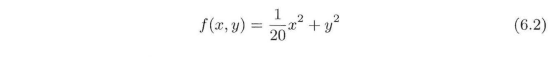

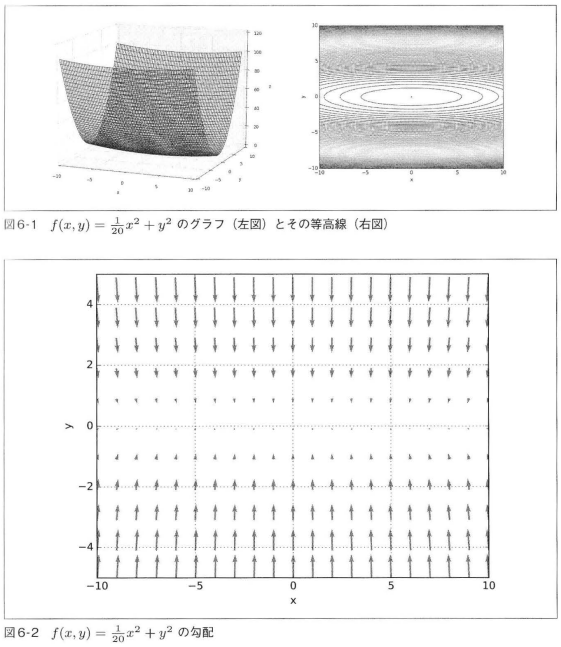

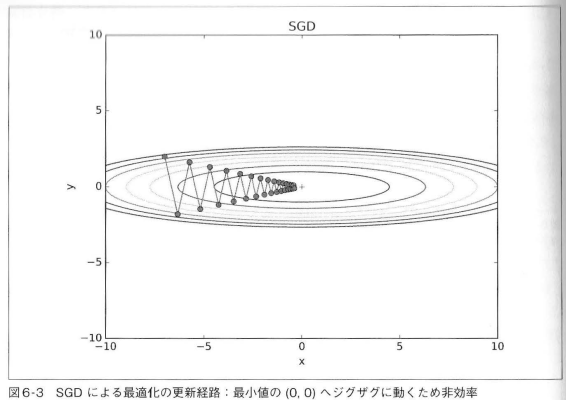

> 6.1.4 Momentum

Momuentum は運動量

位置だけではなく、速度を考える。

（損失関数の勾配 × 学習係数）を、位置ではなく速度から引く。

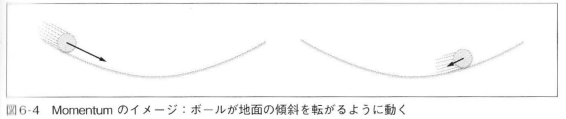

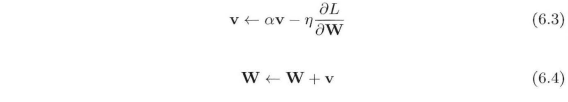

In [15]:
class Momentum:
  def __init__(self, lr=0.01, momuntum=0.9):
    self.lr = lr
    self.momentum = momentum
    self.v = None

  def update(self, params, grads):
    if self.v is None:
      self.v = {}
      for key, val in params.items():
        self.v[key] = np.zeros_like(val)

    for key in params.key():
      self.v[key] = self.momentum * self.v[key] - self.lr*grads[key]
      params[keys] += self.v[keys]

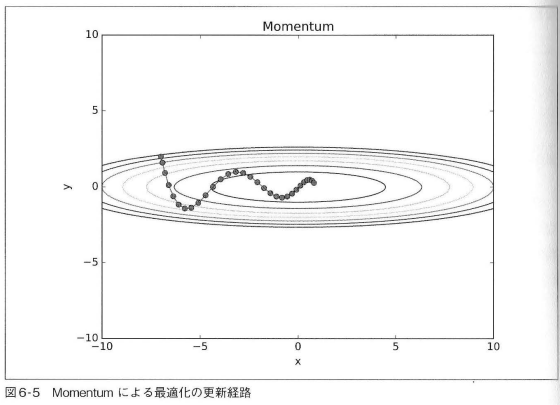

> 6.1.5 AdaGrad

学習係数の減衰、適応的に調整（Adaptive）

ベースはSDG。勾配ベクトルのノルムで学習係数を除算。

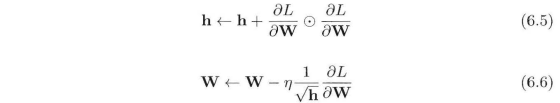

In [16]:
class AdaGrad:
  def __init__(self, lr=0.01):
    self.lr = lr
    self.h = None

  def update(self, params, grads):
    if self.h is None:
      self.h = {}
      for key, val in params.items():
        self.h[key] = np.zeros_like(val)

      for key in params.key():
        self.h[key] += grads[kehy] * grads[key]
        params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key])) + 1e-7

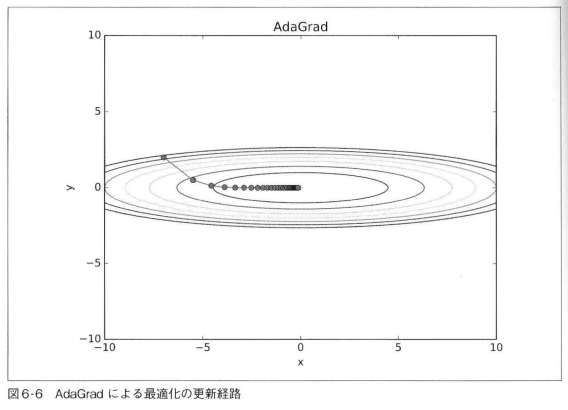

> 6.1.6 Adam

Momentum と AdaGrad の融合。

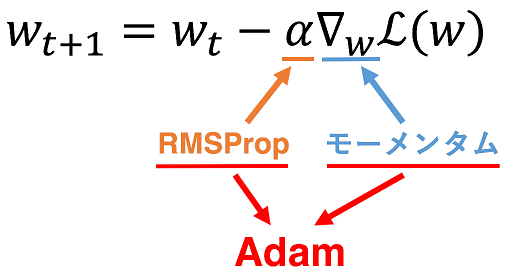

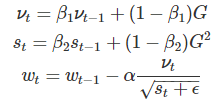

モーメンタム項は、移動平均により振動を抑制することを意味する。

RMSProp は勾配減衰項。

In [17]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

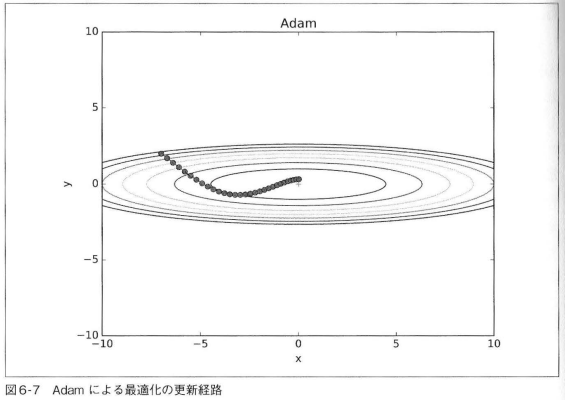

> 6.1.7 どの更新手法を用いるか？

得意不得意がある。

ハイパーパラメータで特性が変わる。

最近では、多くの研究者や技術者は Adam を使う模様。

> 6.1.8 MNIST データセットによる更新手法の比較

common/util.py

In [18]:
# coding: utf-8
import numpy as np


def smooth_curve(x):
    """損失関数のグラフを滑らかにするために用いる
    参考：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]


def shuffle_dataset(x, t):
    """データセットのシャッフルを行う
    Parameters
    ----------
    x : 訓練データ
    t : 教師データ
    Returns
    -------
    x, t : シャッフルを行った訓練データと教師データ
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t

def conv_output_size(input_size, filter_size, stride=1, pad=0):
    return (input_size + 2*pad - filter_size) / stride + 1


def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング
    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad
    Returns
    -------
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

common/function.py

In [19]:
# coding: utf-8
import numpy as np


def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))    


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)
    

def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros_like(x)
    grad[x>=0] = 1
    return grad
    

def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)


def sum_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

common/layers.py

In [20]:
# coding: utf-8
import numpy as np
#from common.functions import *
#from common.util import im2col, col2im


class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx


class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # Conv層の場合は4次元、全結合層の場合は2次元  

        # テスト時に使用する平均と分散
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward時に使用する中間データ
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx


class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


class Pooling:
    def __init__(self, pool_h, pool_w, stride=2, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


common/gradient.py

In [ ]:
# coding: utf-8
import numpy as np

def _numerical_gradient_1d(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        
    return grad


def numerical_gradient_2d(f, X):
    if X.ndim == 1:
        return _numerical_gradient_1d(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_1d(f, x)
        
        return grad


def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

common/multi_layer_net.py

In [22]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from collections import OrderedDict
#from common.layers import *
#from common.gradient import numerical_gradient


class MultiLayerNet:
    """全結合による多層ニューラルネットワーク
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    weight_decay_lambda : Weight Decay（L2ノルム）の強さ
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """重みの初期値設定
        Parameters
        ----------
        weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
            'relu'または'he'を指定した場合は「Heの初期値」を設定
            'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値

            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        損失関数の値
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads

common/optimizer.py

In [23]:
# coding: utf-8
import numpy as np

class SGD:

    """確率的勾配降下法（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 


class Momentum:

    """Momentum SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]


class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]


class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)


mnist.py

In [24]:
# coding: utf-8
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import numpy as np
from pathlib import Path


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = str(Path().resolve()) #os.path.dirname(os.path.abspath(__file__))
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name

    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")

def download_mnist():
    for v in key_file.values():
       _download(v)

def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")

    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")

    return data

def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])

    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1

    return T


def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNISTデータセットの読み込み
    Parameters
    ----------
    normalize : 画像のピクセル値を0.0~1.0に正規化する
    one_hot_label :
        one_hot_labelがTrueの場合、ラベルはone-hot配列として返す
        one-hot配列とは、たとえば[0,0,1,0,0,0,0,0,0,0]のような配列
    flatten : 画像を一次元配列に平にするかどうか
    Returns
    -------
    (訓練画像, 訓練ラベル), (テスト画像, テストラベル)
    """
    if not os.path.exists(save_file):
        init_mnist()

    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)

    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0

    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])

    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])


if __name__ == '__main__':
    init_mnist()


Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


optimizer_compare_mnist.py

===========iteration:0===========
SGD:2.473670730662124
Momentum:2.408884427923609
AdaGrad:2.1330526765312308
Adam:2.2356629700590336
===========iteration:100===========
SGD:1.558434363766969
Momentum:0.28767993967197314
AdaGrad:0.12627667376427565
Adam:0.22070792954354695
===========iteration:200===========
SGD:0.8363420861242039
Momentum:0.23587144183791417
AdaGrad:0.11725548242605775
Adam:0.1655836014024025
===========iteration:300===========
SGD:0.5744175990317029
Momentum:0.2365241342220682
AdaGrad:0.07777117057570986
Adam:0.12749191375517435
===========iteration:400===========
SGD:0.38812897189561973
Momentum:0.209014084700613
AdaGrad:0.11536198994246154
Adam:0.16524047548099507
===========iteration:500===========
SGD:0.37254567263839883
Momentum:0.12730329568547702
AdaGrad:0.06870466739570237
Adam:0.12573818515751478
===========iteration:600===========
SGD:0.2932428426648289
Momentum:0.08651581654510704
AdaGrad:0.054230378974370996
Adam:0.050517090166119105
===========iteration:

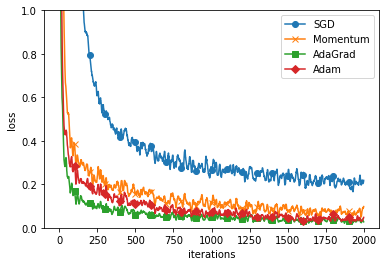

In [25]:
# coding: utf-8
import os
import sys
#sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import matplotlib.pyplot as plt
#from dataset.mnist import load_mnist
#import keras
#from keras.datasets import mnist
#from common.util import smooth_curve
#from common.multi_layer_net import MultiLayerNet
#from common.optimizer import *


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

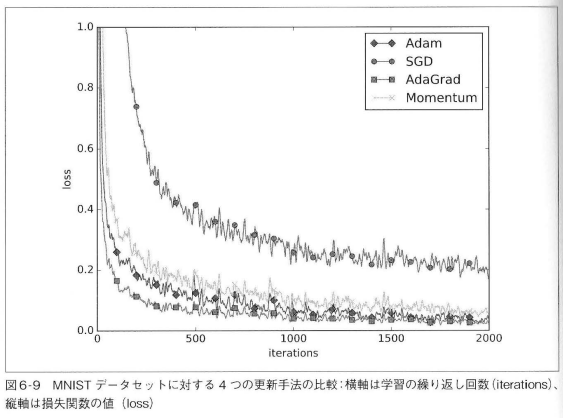

6.2 重みの初期値

> 6.2.1 重みの初期値を0にする？

過学習を抑え、汎化性能を高めるテクニックとして、Weight decay（荷重減衰）がある。

ゼロはNG。何も伝搬しなくなる。

重みが均一になってしまうのもダメ。うまくランダムに振りたい。

> 6.2.2 隠れ層のアクティベーション分布

隠れ層のアクティベーション（活性化関数の後の出力データ）の分布を観察

入力データとしてガウス分布で1,000のデータをランダム作成。

重みをランダムで降る。活性化関数の値を観察する。

0や1に偏るとNG。

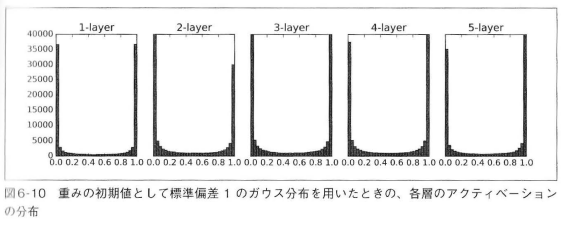

0.5付近ばかりだと消失問題は起きないが、偏りが起こる。

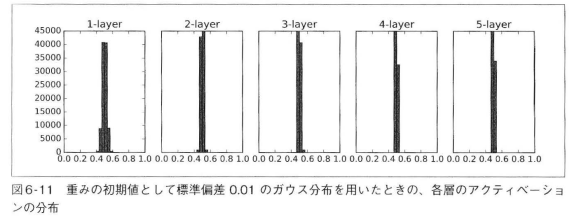

Xavier の初期値（1/√n の標準偏差を持つ分布）　※活性化関数が sigmoid の場合

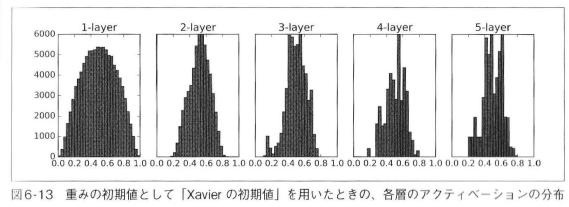

weight_init_activation_histogram.py

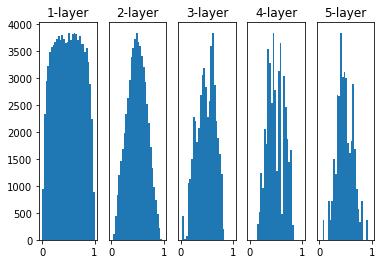

In [29]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

> 6.2.3 ReLU の場合の重みの初期値

2/√n の標準偏差を持つ分布　※（Xavier の 1/√n より広がりが大きい）

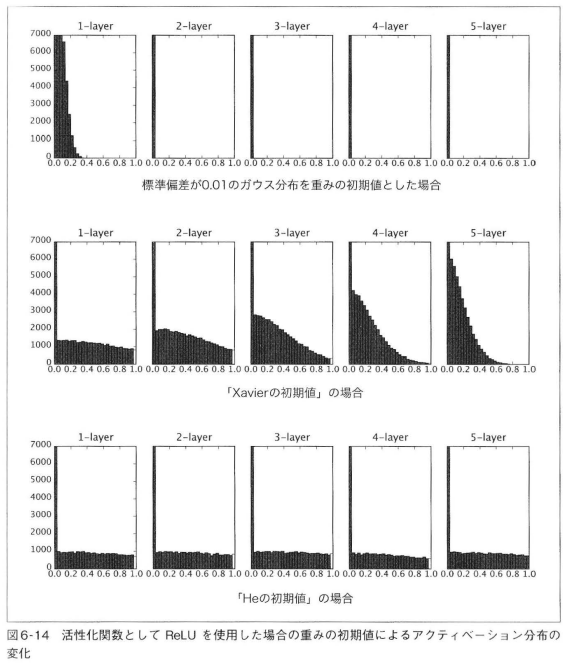

> 6.2.4 MNIST データセットによる重み初期値の比較

weight_init_compare.py

===========iteration:0===========
std=0.01:2.302551079855475
Xavier:2.3084487222522885
He:2.271591129993314
===========iteration:100===========
std=0.01:2.3007782771615117
Xavier:2.258623228215672
He:1.1894481933580974
===========iteration:200===========
std=0.01:2.3035447408765766
Xavier:2.1283503573664704
He:0.7869699610051929
===========iteration:300===========
std=0.01:2.3016945397806627
Xavier:1.8778430069785241
He:0.44096876729704404
===========iteration:400===========
std=0.01:2.301311717454084
Xavier:1.41630781209443
He:0.5804309245407293
===========iteration:500===========
std=0.01:2.301622347050512
Xavier:0.9300155813221087
He:0.30248239468617105
===========iteration:600===========
std=0.01:2.3013905601961886
Xavier:0.6649446027501377
He:0.2964837733191721
===========iteration:700===========
std=0.01:2.2999791544688106
Xavier:0.4902697365105947
He:0.26894985062999244
===========iteration:800===========
std=0.01:2.3009913003239335
Xavier:0.4962675007337187
He:0.234577681942514

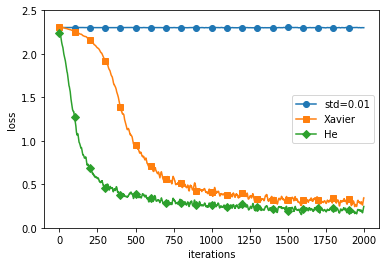

In [31]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
# from dataset.mnist import load_mnist
# from common.util import smooth_curve
# from common.multi_layer_net import MultiLayerNet
# from common.optimizer import SGD


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()


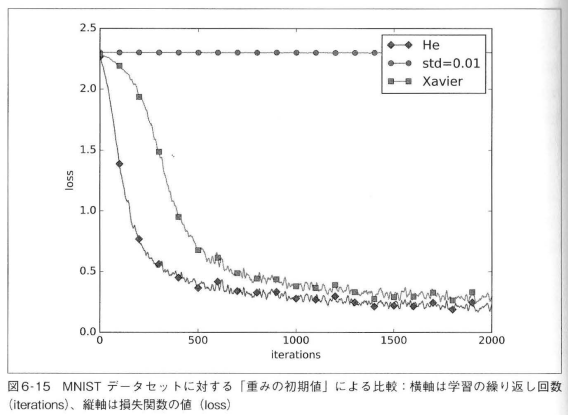

6.3 Batch Normalization

先ほどは重みの初期値を調整することでアクティベーション分布を広げた。

ここでは、アクティベーション分布が広がるような層を強制的に追加するのがアイデア。

> 6.3.1 Batch Normalization のアルゴリズム

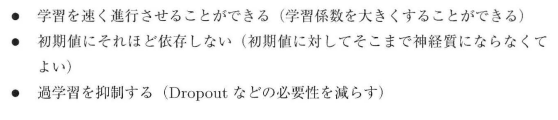

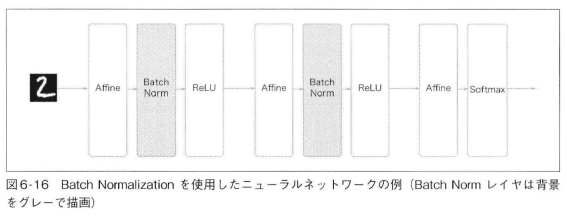

前処理：ミニバッチごとに、入力データの分布が平均0、分散が1になるように正規化する。

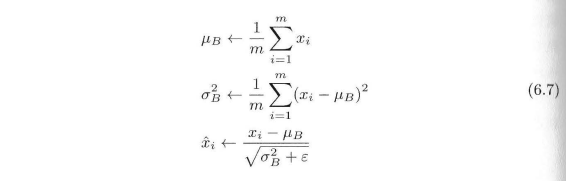

Batch Norm レイヤでは、スケールとシフトで返還を施す。

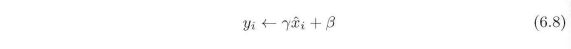

逆伝搬

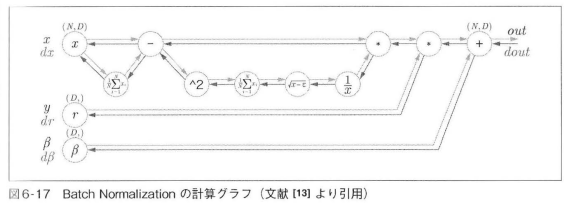

multi_layer_net_extend.py

> 6.3.2 Batch Normalization の評価

In [35]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir) # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from collections import OrderedDict
#from common.layers import *
#from common.gradient import numerical_gradient

class MultiLayerNetExtend:
    """拡張版の全結合による多層ニューラルネットワーク
    
    Weiht Decay、Dropout、Batch Normalizationの機能を持つ
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    weight_decay_lambda : Weight Decay（L2ノルム）の強さ
    use_dropout: Dropoutを使用するかどうか
    dropout_ration : Dropoutの割り合い
    use_batchNorm: Batch Normalizationを使用するかどうか
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0, 
                 use_dropout = False, dropout_ration = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])
                
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            
            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ration)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """重みの初期値設定
        Parameters
        ----------
        weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
            'relu'または'he'を指定した場合は「Heの初期値」を設定
            'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg=False):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x, train_flg=False)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_W = lambda W: self.loss(x, t, train_flg=True)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])
            
            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = numerical_gradient(loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(loss_W, self.params['beta' + str(idx)])

        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads

batch_norm_test.py

============== 1/16 ==============
epoch:0 | 0.092 - 0.064
epoch:1 | 0.1 - 0.088
epoch:2 | 0.1 - 0.101
epoch:3 | 0.1 - 0.127
epoch:4 | 0.1 - 0.15
epoch:5 | 0.116 - 0.173
epoch:6 | 0.116 - 0.2
epoch:7 | 0.116 - 0.211
epoch:8 | 0.116 - 0.237
epoch:9 | 0.116 - 0.258
epoch:10 | 0.116 - 0.285
epoch:11 | 0.116 - 0.307
epoch:12 | 0.116 - 0.32
epoch:13 | 0.116 - 0.342
epoch:14 | 0.116 - 0.364
epoch:15 | 0.116 - 0.378
epoch:16 | 0.117 - 0.381
epoch:17 | 0.116 - 0.398
epoch:18 | 0.116 - 0.405


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.421
============== 2/16 ==============
epoch:0 | 0.117 - 0.099


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


epoch:1 | 0.097 - 0.115
epoch:2 | 0.097 - 0.116
epoch:3 | 0.097 - 0.159
epoch:4 | 0.097 - 0.18
epoch:5 | 0.097 - 0.207
epoch:6 | 0.097 - 0.234
epoch:7 | 0.097 - 0.252
epoch:8 | 0.097 - 0.272
epoch:9 | 0.097 - 0.296
epoch:10 | 0.097 - 0.327
epoch:11 | 0.097 - 0.336
epoch:12 | 0.097 - 0.355
epoch:13 | 0.097 - 0.377
epoch:14 | 0.097 - 0.406
epoch:15 | 0.097 - 0.42
epoch:16 | 0.097 - 0.443
epoch:17 | 0.097 - 0.467
epoch:18 | 0.097 - 0.478


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.494
============== 3/16 ==============
epoch:0 | 0.108 - 0.106
epoch:1 | 0.39 - 0.092
epoch:2 | 0.533 - 0.134
epoch:3 | 0.625 - 0.176
epoch:4 | 0.672 - 0.223
epoch:5 | 0.735 - 0.252
epoch:6 | 0.76 - 0.299
epoch:7 | 0.778 - 0.336
epoch:8 | 0.832 - 0.371
epoch:9 | 0.878 - 0.417
epoch:10 | 0.894 - 0.442
epoch:11 | 0.922 - 0.469
epoch:12 | 0.937 - 0.494
epoch:13 | 0.936 - 0.526
epoch:14 | 0.949 - 0.549
epoch:15 | 0.958 - 0.57
epoch:16 | 0.968 - 0.591
epoch:17 | 0.977 - 0.618
epoch:18 | 0.979 - 0.634


No handles with labels found to put in legend.


epoch:19 | 0.98 - 0.647
============== 4/16 ==============
epoch:0 | 0.114 - 0.046
epoch:1 | 0.251 - 0.09
epoch:2 | 0.376 - 0.191
epoch:3 | 0.443 - 0.262
epoch:4 | 0.518 - 0.345
epoch:5 | 0.57 - 0.402
epoch:6 | 0.617 - 0.448
epoch:7 | 0.652 - 0.499
epoch:8 | 0.684 - 0.531
epoch:9 | 0.702 - 0.568
epoch:10 | 0.733 - 0.59
epoch:11 | 0.754 - 0.62
epoch:12 | 0.764 - 0.646
epoch:13 | 0.786 - 0.666
epoch:14 | 0.797 - 0.685
epoch:15 | 0.816 - 0.709
epoch:16 | 0.826 - 0.716
epoch:17 | 0.847 - 0.731
epoch:18 | 0.858 - 0.746


No handles with labels found to put in legend.


epoch:19 | 0.863 - 0.759
============== 5/16 ==============
epoch:0 | 0.13 - 0.113
epoch:1 | 0.146 - 0.121
epoch:2 | 0.162 - 0.245
epoch:3 | 0.179 - 0.38
epoch:4 | 0.198 - 0.472
epoch:5 | 0.201 - 0.551
epoch:6 | 0.218 - 0.606
epoch:7 | 0.227 - 0.648
epoch:8 | 0.237 - 0.685
epoch:9 | 0.246 - 0.716
epoch:10 | 0.255 - 0.746
epoch:11 | 0.264 - 0.767
epoch:12 | 0.285 - 0.779
epoch:13 | 0.282 - 0.798
epoch:14 | 0.28 - 0.805
epoch:15 | 0.293 - 0.812
epoch:16 | 0.299 - 0.829
epoch:17 | 0.309 - 0.835
epoch:18 | 0.318 - 0.857


No handles with labels found to put in legend.


epoch:19 | 0.328 - 0.859
============== 6/16 ==============
epoch:0 | 0.118 - 0.086
epoch:1 | 0.129 - 0.234
epoch:2 | 0.122 - 0.472
epoch:3 | 0.116 - 0.623
epoch:4 | 0.116 - 0.691
epoch:5 | 0.116 - 0.736
epoch:6 | 0.116 - 0.781
epoch:7 | 0.116 - 0.805
epoch:8 | 0.116 - 0.835
epoch:9 | 0.119 - 0.853
epoch:10 | 0.116 - 0.875
epoch:11 | 0.116 - 0.883
epoch:12 | 0.116 - 0.895
epoch:13 | 0.131 - 0.906
epoch:14 | 0.124 - 0.914
epoch:15 | 0.116 - 0.917
epoch:16 | 0.116 - 0.931
epoch:17 | 0.116 - 0.938
epoch:18 | 0.116 - 0.945


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.953
============== 7/16 ==============
epoch:0 | 0.1 - 0.099
epoch:1 | 0.097 - 0.168
epoch:2 | 0.116 - 0.551
epoch:3 | 0.116 - 0.71
epoch:4 | 0.116 - 0.779
epoch:5 | 0.116 - 0.815
epoch:6 | 0.116 - 0.853
epoch:7 | 0.116 - 0.875
epoch:8 | 0.116 - 0.904
epoch:9 | 0.116 - 0.921
epoch:10 | 0.116 - 0.932
epoch:11 | 0.116 - 0.939
epoch:12 | 0.116 - 0.948
epoch:13 | 0.116 - 0.96
epoch:14 | 0.116 - 0.966
epoch:15 | 0.116 - 0.972
epoch:16 | 0.116 - 0.974
epoch:17 | 0.116 - 0.98
epoch:18 | 0.124 - 0.984


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.988
============== 8/16 ==============
epoch:0 | 0.097 - 0.17
epoch:1 | 0.116 - 0.451
epoch:2 | 0.116 - 0.604
epoch:3 | 0.116 - 0.666
epoch:4 | 0.116 - 0.735
epoch:5 | 0.116 - 0.805
epoch:6 | 0.116 - 0.841
epoch:7 | 0.116 - 0.878
epoch:8 | 0.116 - 0.917
epoch:9 | 0.116 - 0.948
epoch:10 | 0.116 - 0.974
epoch:11 | 0.116 - 0.984
epoch:12 | 0.116 - 0.988
epoch:13 | 0.116 - 0.991
epoch:14 | 0.116 - 0.994
epoch:15 | 0.116 - 0.995
epoch:16 | 0.116 - 0.998
epoch:17 | 0.116 - 0.997
epoch:18 | 0.116 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.999
============== 9/16 ==============
epoch:0 | 0.093 - 0.11
epoch:1 | 0.117 - 0.534
epoch:2 | 0.117 - 0.655
epoch:3 | 0.117 - 0.701
epoch:4 | 0.117 - 0.761
epoch:5 | 0.117 - 0.848
epoch:6 | 0.117 - 0.863
epoch:7 | 0.117 - 0.891
epoch:8 | 0.117 - 0.9
epoch:9 | 0.117 - 0.915
epoch:10 | 0.117 - 0.973
epoch:11 | 0.117 - 0.985
epoch:12 | 0.117 - 0.99
epoch:13 | 0.117 - 0.994
epoch:14 | 0.117 - 0.997
epoch:15 | 0.117 - 0.997
epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.997
epoch:18 | 0.117 - 0.997


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.997
============== 10/16 ==============
epoch:0 | 0.105 - 0.112
epoch:1 | 0.116 - 0.547
epoch:2 | 0.116 - 0.786
epoch:3 | 0.116 - 0.838
epoch:4 | 0.117 - 0.873
epoch:5 | 0.117 - 0.942
epoch:6 | 0.116 - 0.953
epoch:7 | 0.116 - 0.983
epoch:8 | 0.116 - 0.985
epoch:9 | 0.116 - 0.986
epoch:10 | 0.116 - 0.994
epoch:11 | 0.116 - 0.993
epoch:12 | 0.116 - 0.998
epoch:13 | 0.116 - 0.996
epoch:14 | 0.116 - 0.999
epoch:15 | 0.116 - 1.0
epoch:16 | 0.116 - 1.0
epoch:17 | 0.116 - 1.0
epoch:18 | 0.116 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.116 - 1.0
============== 11/16 ==============
epoch:0 | 0.117 - 0.15
epoch:1 | 0.117 - 0.515
epoch:2 | 0.117 - 0.704
epoch:3 | 0.117 - 0.753
epoch:4 | 0.117 - 0.753
epoch:5 | 0.117 - 0.785
epoch:6 | 0.117 - 0.794
epoch:7 | 0.117 - 0.797
epoch:8 | 0.117 - 0.847
epoch:9 | 0.117 - 0.806
epoch:10 | 0.117 - 0.798
epoch:11 | 0.117 - 0.929
epoch:12 | 0.117 - 0.95
epoch:13 | 0.117 - 0.982
epoch:14 | 0.117 - 0.978
epoch:15 | 0.117 - 0.988
epoch:16 | 0.117 - 0.986
epoch:17 | 0.117 - 0.988
epoch:18 | 0.117 - 0.989


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.99
============== 12/16 ==============
epoch:0 | 0.116 - 0.311
epoch:1 | 0.116 - 0.454
epoch:2 | 0.116 - 0.697
epoch:3 | 0.116 - 0.762
epoch:4 | 0.116 - 0.754
epoch:5 | 0.116 - 0.757
epoch:6 | 0.116 - 0.783
epoch:7 | 0.116 - 0.776
epoch:8 | 0.116 - 0.789
epoch:9 | 0.116 - 0.796
epoch:10 | 0.116 - 0.823
epoch:11 | 0.116 - 0.869
epoch:12 | 0.116 - 0.872
epoch:13 | 0.116 - 0.86
epoch:14 | 0.116 - 0.853
epoch:15 | 0.116 - 0.88
epoch:16 | 0.116 - 0.82
epoch:17 | 0.116 - 0.814
epoch:18 | 0.116 - 0.808


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.809
============== 13/16 ==============
epoch:0 | 0.092 - 0.199
epoch:1 | 0.105 - 0.541
epoch:2 | 0.116 - 0.509
epoch:3 | 0.116 - 0.617
epoch:4 | 0.116 - 0.711
epoch:5 | 0.116 - 0.704
epoch:6 | 0.116 - 0.658
epoch:7 | 0.117 - 0.69
epoch:8 | 0.116 - 0.701
epoch:9 | 0.116 - 0.703
epoch:10 | 0.116 - 0.689
epoch:11 | 0.116 - 0.708
epoch:12 | 0.116 - 0.7
epoch:13 | 0.116 - 0.709
epoch:14 | 0.116 - 0.709
epoch:15 | 0.116 - 0.731
epoch:16 | 0.116 - 0.883
epoch:17 | 0.116 - 0.863
epoch:18 | 0.116 - 0.896


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.877
============== 14/16 ==============
epoch:0 | 0.097 - 0.136
epoch:1 | 0.117 - 0.419
epoch:2 | 0.117 - 0.466
epoch:3 | 0.117 - 0.497
epoch:4 | 0.117 - 0.497
epoch:5 | 0.117 - 0.51
epoch:6 | 0.117 - 0.515
epoch:7 | 0.117 - 0.516
epoch:8 | 0.117 - 0.533
epoch:9 | 0.117 - 0.591
epoch:10 | 0.117 - 0.612
epoch:11 | 0.117 - 0.609
epoch:12 | 0.117 - 0.614
epoch:13 | 0.117 - 0.607
epoch:14 | 0.117 - 0.616
epoch:15 | 0.117 - 0.542
epoch:16 | 0.117 - 0.596
epoch:17 | 0.117 - 0.619
epoch:18 | 0.116 - 0.616


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.62
============== 15/16 ==============
epoch:0 | 0.094 - 0.178
epoch:1 | 0.116 - 0.291
epoch:2 | 0.117 - 0.405
epoch:3 | 0.116 - 0.353
epoch:4 | 0.116 - 0.511
epoch:5 | 0.116 - 0.519
epoch:6 | 0.117 - 0.572
epoch:7 | 0.117 - 0.528
epoch:8 | 0.117 - 0.591
epoch:9 | 0.117 - 0.51
epoch:10 | 0.117 - 0.561
epoch:11 | 0.117 - 0.57
epoch:12 | 0.117 - 0.6
epoch:13 | 0.117 - 0.583
epoch:14 | 0.117 - 0.602
epoch:15 | 0.117 - 0.592
epoch:16 | 0.117 - 0.614
epoch:17 | 0.117 - 0.605
epoch:18 | 0.117 - 0.571


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.608
============== 16/16 ==============
epoch:0 | 0.1 - 0.248
epoch:1 | 0.093 - 0.219
epoch:2 | 0.117 - 0.309
epoch:3 | 0.117 - 0.384
epoch:4 | 0.117 - 0.402
epoch:5 | 0.117 - 0.479
epoch:6 | 0.117 - 0.489
epoch:7 | 0.117 - 0.485
epoch:8 | 0.116 - 0.499
epoch:9 | 0.116 - 0.505
epoch:10 | 0.116 - 0.505
epoch:11 | 0.116 - 0.51
epoch:12 | 0.116 - 0.461
epoch:13 | 0.116 - 0.508
epoch:14 | 0.116 - 0.513
epoch:15 | 0.116 - 0.513
epoch:16 | 0.116 - 0.503
epoch:17 | 0.116 - 0.509
epoch:18 | 0.116 - 0.516
epoch:19 | 0.117 - 0.518


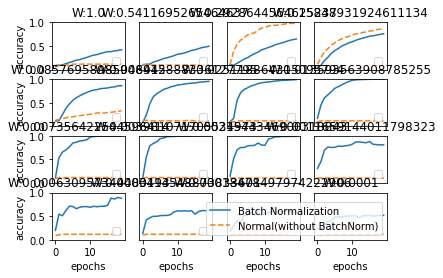

In [36]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
#from dataset.mnist import load_mnist
#from common.multi_layer_net_extend import MultiLayerNetExtend
#from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 3.グラフの描画==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

たいていの場合は Batch Normalization の方がベター。

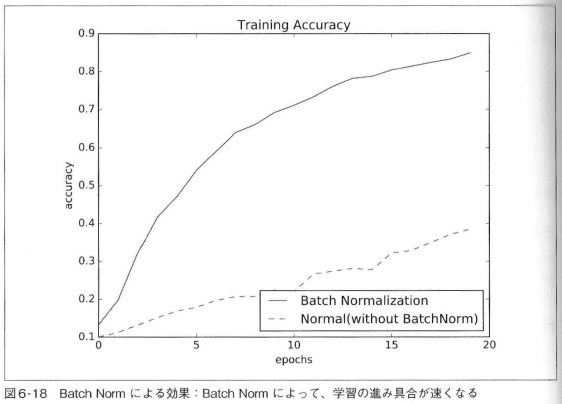

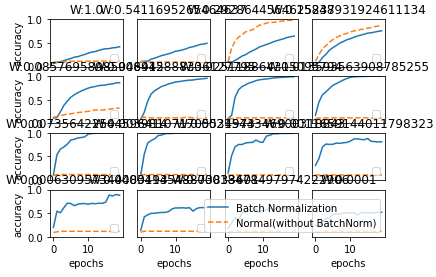

6.4 正則化

> 6.4.1 過学習

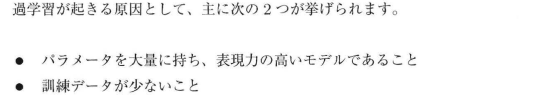

わざと過学習をさせてみる。

overfit_weight_decay.py

epoch:0, train acc:0.13, test acc:0.1054
epoch:1, train acc:0.14666666666666667, test acc:0.1189
epoch:2, train acc:0.16, test acc:0.1292
epoch:3, train acc:0.16666666666666666, test acc:0.1373
epoch:4, train acc:0.16666666666666666, test acc:0.1416
epoch:5, train acc:0.21333333333333335, test acc:0.1604
epoch:6, train acc:0.22666666666666666, test acc:0.1741
epoch:7, train acc:0.25333333333333335, test acc:0.1821
epoch:8, train acc:0.27, test acc:0.194
epoch:9, train acc:0.27666666666666667, test acc:0.2033
epoch:10, train acc:0.32, test acc:0.2263
epoch:11, train acc:0.3433333333333333, test acc:0.2378
epoch:12, train acc:0.3566666666666667, test acc:0.248
epoch:13, train acc:0.37666666666666665, test acc:0.2657
epoch:14, train acc:0.38666666666666666, test acc:0.278
epoch:15, train acc:0.3933333333333333, test acc:0.2816
epoch:16, train acc:0.38666666666666666, test acc:0.2871
epoch:17, train acc:0.41, test acc:0.3002
epoch:18, train acc:0.43, test acc:0.3123
epoch:19, train acc:0.4

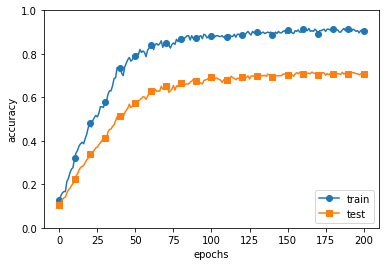

In [37]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
#from dataset.mnist import load_mnist
#from common.multi_layer_net import MultiLayerNet
#from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
#weight_decay_lambda = 0 # weight decayを使用しない場合
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

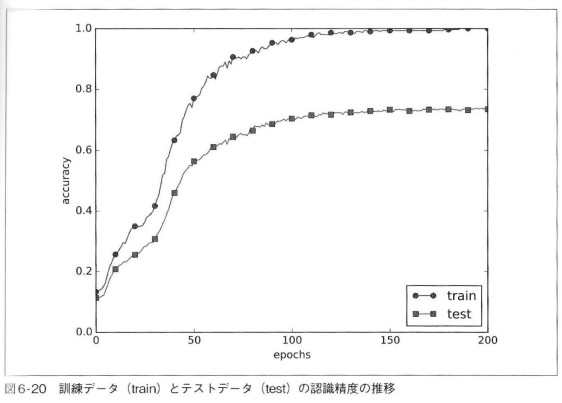

> 6.4.2 Weight decay

重みが大きすぎる場合にペナルティを課す。重みが大きいことが過学習につながるので。

1/2 λW^2 を損失関数に加算する。（L2ノルム）

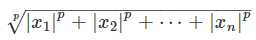

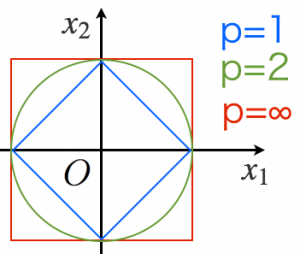

image.png

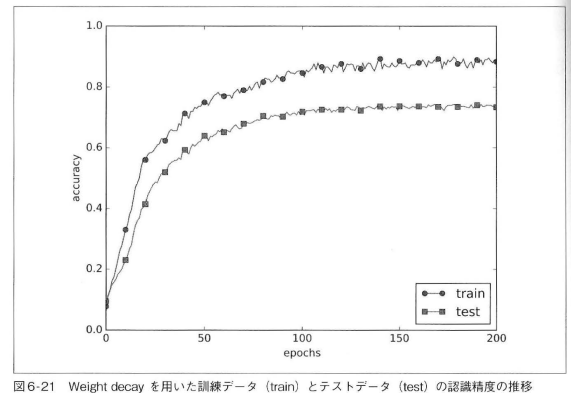

> 6.4.3 Dropout

ネットワークが大きくなると Weight decay では対応しきれなくなる。

ランダムにニューロンを削除して、意図的にネットワークの伝達を阻害する。

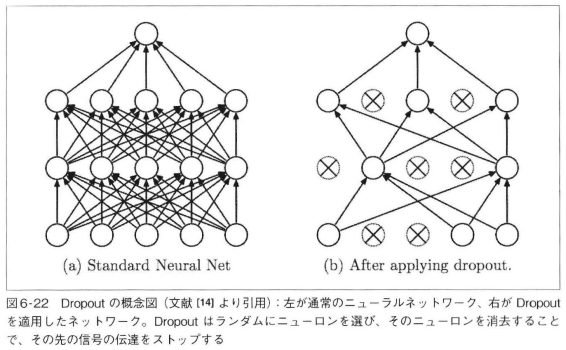

trainer.py 

In [39]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np

class Trainer:
    """ニューラルネットの訓練を行うクラス
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimizer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprop':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))

train loss:2.3358805202294373
=== epoch:1, train acc:0.06, test acc:0.0911 ===
train loss:2.3186178097331047
train loss:2.296929208072887
train loss:2.3186059614338985
=== epoch:2, train acc:0.06333333333333334, test acc:0.0885 ===
train loss:2.314582817317431
train loss:2.311887956647303
train loss:2.305329663603507
=== epoch:3, train acc:0.06333333333333334, test acc:0.0856 ===
train loss:2.3061898062565693
train loss:2.3178185313407087
train loss:2.322912520505119
=== epoch:4, train acc:0.07, test acc:0.0844 ===
train loss:2.319352832036305
train loss:2.317024891349774
train loss:2.3043603562190014
=== epoch:5, train acc:0.07, test acc:0.0812 ===
train loss:2.2799345749113265
train loss:2.293916039311497
train loss:2.3064443471880915
=== epoch:6, train acc:0.06666666666666667, test acc:0.0802 ===
train loss:2.2987874642282105
train loss:2.306400016327651
train loss:2.2938501364240826
=== epoch:7, train acc:0.07333333333333333, test acc:0.0792 ===
train loss:2.3123052570666967
train 

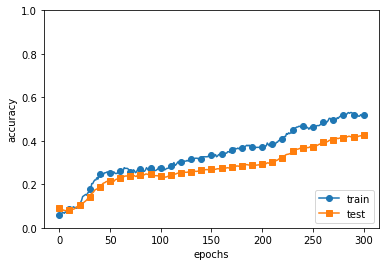

In [40]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuoutの有無、割り合いの設定 ========================
use_dropout = True  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

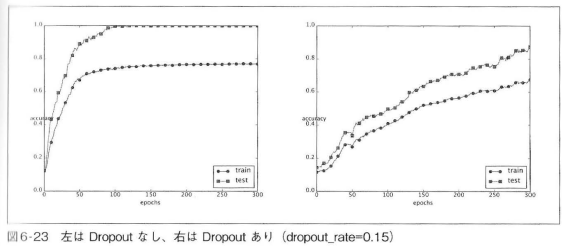

6.5 ハイパーパラメータの検証

各層のニューロン数、バッチサイズ、パラメータ更新の学習係数や Weight decay など。

> 6.5.1 検証データ

テストデータを使ってハイパーパラメータを評価してはいけない。

テストデータで過学習をしてしまうため。

そこで、ハイパーパラメータ専用の検証データ（validation data）を用意する。

1) 訓練データ、2) 検証データ、3) テストデータ、が必要。

> 6.5.2 ハイパーパラメータの最適化


*   ステップ 0 ハイパーパラメータの範囲をざっくり（10^-3～10^3）設定する。
*   ステップ 1 設定されたハイパーパラメータの範囲から、ランダムにサンプリングする。
*   ステップ 2 1 でサンプリングされたハイパーパラメータで学習、検証データで評価。（エポックは小）
*   ステップ 3 1 と 2 を繰り返し、認識制度の結果からハイパーパラメータの範囲を狭める。

※ベイズ最適化が優秀とのこと。

> 6.5.3 ハイパーパラメータ最適化の実装

hyperparameter_optimization.py

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# ハイパーパラメータのランダム探索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 探索したハイパーパラメータの範囲を指定===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# グラフの描画========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

val acc:0.42 | lr:0.002911844108894191, weight decay:1.4523816981255232e-06
val acc:0.14 | lr:7.992006063750307e-06, weight decay:3.0112200681318843e-07
val acc:0.11 | lr:2.795980621927437e-06, weight decay:2.349721984511682e-07
val acc:0.11 | lr:6.0455527114711225e-06, weight decay:2.9023031363795007e-08
val acc:0.82 | lr:0.008965712705467891, weight decay:2.944081213088293e-07
val acc:0.1 | lr:1.0715529383832005e-06, weight decay:6.736811867466918e-06
val acc:0.1 | lr:1.348842579732597e-05, weight decay:5.685029754908612e-05
val acc:0.06 | lr:0.00014123132383274175, weight decay:1.8072990855930498e-08
val acc:0.08 | lr:0.00024284355184754714, weight decay:1.7202693218962173e-08
val acc:0.12 | lr:9.820391022863261e-06, weight decay:3.461836864319733e-05
val acc:0.11 | lr:4.37698998928566e-06, weight decay:4.131590716499449e-08
val acc:0.1 | lr:1.4856143015571189e-05, weight decay:1.0454462119335935e-05
val acc:0.77 | lr:0.009761594393116677, weight decay:1.0114419627287372e-05
val acc

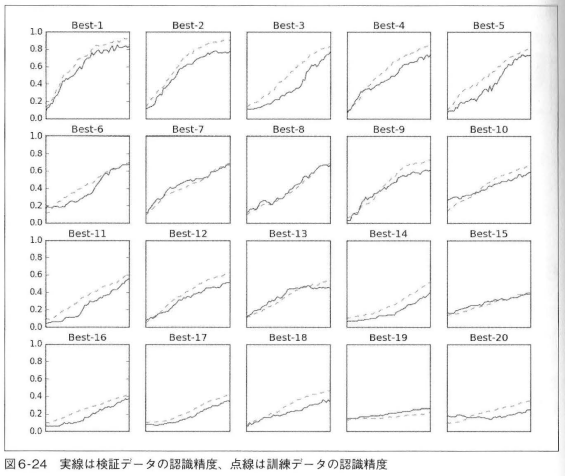

6.6 まとめ

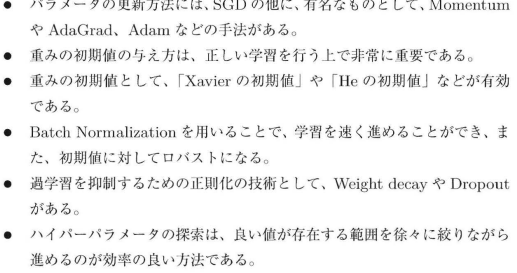